In [1]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import gin
from functools import partial
gin.enter_interactive_mode()

In [2]:
@gin.configurable
def get_xy(h=10, w=10, s=1000):
    res = np.zeros((s, h, w), dtype=np.float32)
    idxes_x = np.random.choice(h, s, replace=True)
    idxes_y = np.random.choice(w, s, replace=True)
    res[np.arange(s), idxes_x, idxes_y] = 1.0
    
    return res, (idxes_x, idxes_y)

In [3]:
h, w, s = 10, 10, 1000
gin.bind_parameter('get_xy.h', h)
gin.bind_parameter('get_xy.w', w)
gin.bind_parameter('get_xy.s', s)

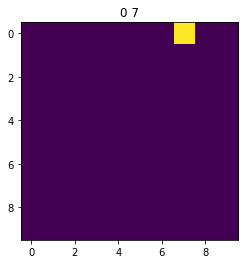

In [4]:
X, (xs, ys) = get_xy()

idx = np.random.choice(s)

plt.title(f"{xs[idx]} {ys[idx]}")
plt.imshow(X[idx])

In [436]:
import torch
from torch import nn
import numpy as np
import gin


@gin.configurable
class PolyFracAct(nn.Module):
    """Polynomial activation function. y = poly(x, w1)/poly(x, w2), w1, w2 is learned."""

    GIVE_N_FEATURES = True

    def __repr__(self, *args, **kwargs):
        orig = super(PolyFracAct, self).__repr__(*args, **kwargs)
        return f"{orig} max_degree={self.max_degree} features={self.features}"

    def __init__(self, features=None, max_degree=3):
        super(PolyFracAct, self).__init__()
        # order: constant, x, x^2, ...
        self.max_degree = max_degree
        if isinstance(features, list) or isinstance(features, tuple):
            features = np.prod(features)
        self.features = features
        self.orig_act = nn.Tanh()
        init = np.random.randn(*(max_degree + 1, features, 2)).astype(np.float32) / 10.
#         init[1, :, :] = 1.0
#         init[2, :, :] = 0.0001
        self.a = nn.Parameter(torch.from_numpy(init), requires_grad=True)

    def forward(self, x):
        xshape = x.shape
        x = x.flatten(start_dim=1)
        assert x.shape[1] == self.features, (x.shape, self.features)

#         if self.orig_act is not None:
#             x = self.orig_act(x)
        
        assert self.max_degree == 3
        out1 = x * self.a[1, :, 0] + x ** 2 * self.a[2, :, 0] + x ** 3 * self.a[3, :, 0] + self.a[0, :, 0]
        out2 = x * self.a[1, :, 1] + x ** 2 * self.a[2, :, 1] + x ** 3 * self.a[3, :, 1] + self.a[0, :, 1]

        out = out1 / out2
        
        x = out.view(*xshape)
        
        if self.orig_act is not None:
            x = self.orig_act(x)
        
        return x


In [437]:
act_cls = lambda **kwargs: nn.Tanh()


from sparse_causal_model_learner_rl.trainable.quadratic_neuron import Quadratic
from sparse_causal_model_learner_rl.trainable.poly_activation import PolyAct
        
# act_cls = partial(PolyAct, orig_act_cls=lambda: (lambda x: x)) # nn.Tanh
act_cls = PolyFracAct
layer_cls = nn.Linear
# layer_cls = Quadratic

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
#         self.fc1 = layer_cls(in_features=h * w, out_features=10)
#         self.fc2 = layer_cls(in_features=10, out_features=4)
        self.fc = nn.Linear(in_features=h*w, out_features=4)
#         self.act = act_cls(features=10)#nn.Tanh()
    def forward(self, x):
        x = x.flatten(start_dim=1)
#         x = self.act(self.fc1(x))
#         x = self.fc2(x)
        x = self.fc(x)
        return x

class Reconstructor(nn.Module):
    def __init__(self):
        super(Reconstructor, self).__init__()
        self.fc1 = layer_cls(in_features=4, out_features=10 * h * w)
        self.fc2 = nn.Linear(in_features=10*h*w, out_features=h * w)
        self.act1 = act_cls(features=10*h*w)#nn.Tanh()
        self.act2 = act_cls(features=h*w)
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = x.view(x.shape[0], h, w)
        return x

In [438]:
rec = Reconstructor()
dec = Decoder()

In [439]:
rec.act1.a

Parameter containing:
tensor([[[ 2.0455e-02, -9.7339e-02],
         [-1.5079e-01, -6.1671e-02],
         [ 8.2404e-02,  5.2305e-02],
         ...,
         [-4.3328e-02,  1.1386e-02],
         [ 2.6230e-02,  1.3062e-01],
         [-8.0069e-02, -2.3260e-01]],

        [[-5.5164e-02,  1.1005e-02],
         [-1.6137e-01,  1.5347e-01],
         [-1.8058e-01, -4.2713e-02],
         ...,
         [ 1.5680e-01,  7.9133e-02],
         [-3.9844e-02, -2.7226e-02],
         [-8.9416e-02, -3.3317e-02]],

        [[ 1.9993e-03, -1.1102e-01],
         [-8.2216e-02, -3.2358e-03],
         [ 1.5982e-01, -6.5152e-02],
         ...,
         [-1.4779e-01,  1.0392e-01],
         [-1.7769e-01,  5.9436e-03],
         [-9.0900e-02, -1.2898e-04]],

        [[ 7.5263e-02,  6.5937e-02],
         [ 7.6496e-02, -1.5039e-01],
         [ 8.8181e-02,  1.3481e-01],
         ...,
         [-6.7409e-02,  8.2873e-02],
         [-5.8940e-02, -1.9432e-02],
         [ 3.9831e-02, -2.5085e-01]]], requires_grad=True)

In [440]:
data = torch.from_numpy(X)

In [441]:
def loss():
#     softmaxed = torch.nn.Softmax(1)(rec(dec(data)).flatten(start_dim=1))
#     answers = torch.argmax(data.flatten(start_dim=1), dim=1)
    
#     ce = torch.nn.CrossEntropyLoss()
#     loss = ce(softmaxed, answers)
   
#     delta = (rec(dec(data)) - data).flatten(start_dim=1)
#     std = data.std(0, keepdim=True).flatten(start_dim=1)
#     std = torch.where(std < 1e-6, torch.ones_like(std), std)
#     delta = delta.pow(2)
#     delta = delta / std.pow(2)
#     loss = delta.sum(1).mean(0)
    delta = (rec(dec(data)) - data).flatten(start_dim=1)
    loss = delta.pow(2).sum(1).mean(0)
    return loss

In [442]:
opt = torch.optim.Adam(list(rec.parameters()) + list(dec.parameters()),
                       lr=1e-3)

In [443]:
losses = []

In [457]:
for i in tqdm(range(10000)):
    if i % 10 == 0:
        X, (xs, ys) = get_xy()
        data = torch.from_numpy(X)
    
    opt.zero_grad()
    l = loss()
    l.backward()
    opt.step()
    losses.append(l.item())

KeyboardInterrupt: 

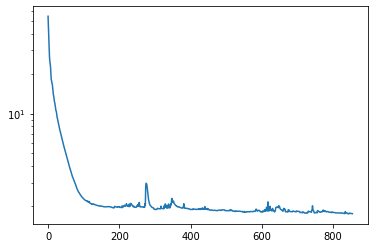

In [458]:
plt.plot(losses)
plt.yscale('log')

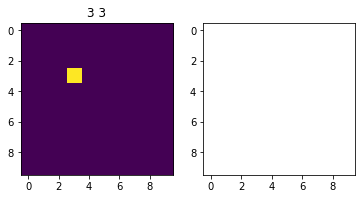

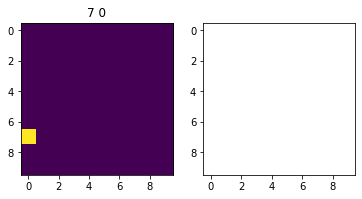

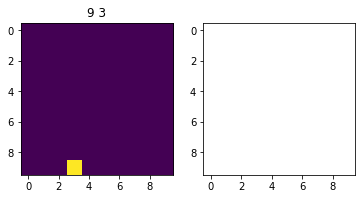

In [459]:
X, (xs, ys) = get_xy()
data = torch.from_numpy(X)

Xrec = rec(dec(data))
for _ in range(3):
    idx = np.random.choice(s)

    plt.subplot(1, 2, 1)
    plt.title(f"{xs[idx]} {ys[idx]}")
    plt.imshow(X[idx])
    plt.subplot(1, 2, 2)
    xrecnp = Xrec.detach().cpu().numpy()[idx]
    plt.imshow(xrecnp, vmin=0, vmax=1)# >= np.max(xrecnp))
    plt.show()

In [460]:
plt.imshow

<function matplotlib.pyplot.imshow>

In [461]:
plt.imshow(rec.fc1.W[7, :, :].detach().numpy())

AttributeError: 'Linear' object has no attribute 'W'

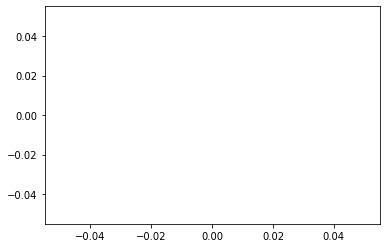

In [462]:
xs = np.linspace(-10, 10, 100)
idx = 1
xs_ = np.tanh(xs)
pows = [np.power(xs_, i) for i in range(4)]
xs_pows1 = rec.act1.a[:, idx:idx+1, 0].detach().cpu().numpy() * np.array(pows)
xs_pows2 = rec.act1.a[:, idx:idx+1, 1].detach().cpu().numpy() * np.array(pows)
p1 = np.sum(xs_pows1, axis=0)
p2 = np.sum(xs_pows2, axis=0)
p = p1 / p2
# p = np.tanh(p)
plt.plot(xs, p)

In [463]:
rec.act1.a[:, idx:idx+1, 0], rec.act1.a[:, idx:idx+1, 1]

(tensor([[nan],
         [nan],
         [nan],
         [nan]], grad_fn=<SelectBackward>), tensor([[nan],
         [nan],
         [nan],
         [nan]], grad_fn=<SelectBackward>))

In [453]:
rec.act1.a[:, idx:idx+1, 0].detach().cpu().numpy().shape, np.array(pows).shape

((4, 1), (4, 100))